In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from util import  *


%matplotlib inline

In [8]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/home/aims/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [9]:
data['sentiment'] = data['description'].apply(lambda x : sentiment_analyzer_scores(x,'compound'))

In [10]:
data.shape

(258210, 17)

In [11]:
test.shape

(83210, 16)

In [14]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,sentiment
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos,3
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,3
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,3
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,3


In [15]:
data['title'].mode().values


array(['Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)'],
      dtype=object)

In [16]:
data.region_1.fillna(value='Napa Valley',inplace=True)

In [17]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [18]:
data.province.fillna(value='California', inplace=True)

In [19]:
data = data[pd.notnull(data['region_1'])]
data = data[pd.notnull(data['variety'])]
data = data[pd.notnull(data['province'])]

In [20]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 17 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 258210 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
sentiment                258210 non-null int64
dtypes: float64(3), int64(2), object(12)
memory usage: 35.5+ MB


In [21]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 17 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 258210 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
sentiment                258210 non-null int64
dtypes: float64(3), int64(2), object(12)
memory usage: 35.5+ MB


In [22]:
data.title.nunique()

110638

In [23]:
data['sentiment'] = pd.Categorical(data['sentiment'])
sentiDummies = pd.get_dummies(data['sentiment'], prefix = 'sentiment')

data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')


data['region_1'] = pd.Categorical(data['region_1'])
regionDummies = pd.get_dummies(data['region_1'],prefix='region_1')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [24]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [25]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [26]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,sentiment,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,Napa Valley,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,3,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,3,2
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,Roger Voss,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,3,2
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,3,2


In [27]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [28]:
data['region_1'] = data['region_1'].str.replace('\d+','')
data['region_1'] = data.region_1.apply(func=remove_punctuation)
data['region_1'] = data.region_1.apply(func=make_lower_case)

In [29]:
data["winery"] = data["winery"].str.replace('\d+', '')
data["winery"] = data.winery.apply(func=remove_punctuation)
data["winery"] = data.winery.apply(func=make_lower_case)

In [30]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [31]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [32]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [33]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [34]:
data['desc_count'] = data['description'].apply(lambda x:len(str(x)))

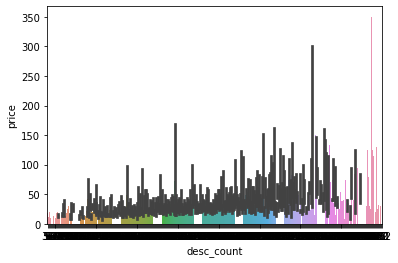

In [36]:
sns.barplot(x='desc_count',y='price',data=data.sample(3000))

In [37]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.winery)
winery_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["winery_" + s for s in collist]
winery_features.columns = collist
winery_features.head()

,winery_0,winery_1,winery_2,winery_3,winery_4,winery_5,winery_6,winery_7,winery_8,winery_9
0,-1.118029e-06,-4.108786e-06,0.000091,0.000088,0.000150,0.001905,-0.002878,0.005086,0.029046,0.001170
1,2.217665e-01,7.029981e-04,0.000038,-0.011386,0.000083,0.000819,-0.000175,-0.000028,-0.000324,0.000182
2,3.952938e-01,-6.586275e-03,-0.000049,-0.027108,0.000051,-0.000691,0.000210,-0.000714,0.000549,-0.000078
3,2.458258e-08,-4.796603e-07,-0.000003,-0.000003,-0.000013,0.000032,0.000036,0.000068,0.000065,0.000006
4,1.121917e-08,-2.947081e-06,0.000004,-0.000020,-0.000039,0.000106,0.000253,0.000379,0.000301,-0.000011


In [38]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9
0,0.115367,0.004840,0.114661,0.050377,0.006808,-0.029133,-0.025117,0.051007,0.004268,-0.012613
1,0.119707,0.024667,0.072517,0.022312,-0.013160,-0.064644,-0.003263,0.027463,-0.004231,0.005966
2,0.129262,0.101725,0.087982,0.004308,0.130393,-0.034107,-0.014267,0.040808,0.055634,-0.009202
3,0.103500,0.062217,0.011668,-0.065489,-0.019584,-0.064958,-0.006608,0.011069,0.063368,0.027147
4,0.096223,-0.057049,-0.015558,-0.011770,0.024920,0.029818,0.006138,-0.003928,-0.032095,0.037746


In [39]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9
0,3.179084e-06,1.304745e-05,4.913912e-02,2.476378e-01,-0.000036,4.353693e-04,0.000033,0.000074,0.000059,-0.182527
1,1.026852e-05,4.066264e-05,1.488019e-01,7.480541e-01,-0.000136,8.564388e-04,0.000100,-0.000155,-0.000344,0.613686
2,1.026852e-05,4.066264e-05,1.488019e-01,7.480541e-01,-0.000136,8.564388e-04,0.000100,-0.000155,-0.000344,0.613686
3,1.601717e-08,1.380437e-06,2.276778e-06,6.575477e-07,-0.000205,-3.688356e-05,0.000706,0.000194,0.001465,0.000101
4,-1.348023e-08,2.475735e-09,8.840960e-07,4.236564e-06,-0.000002,6.202651e-07,-0.000003,0.000025,0.000160,-0.000461


In [40]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9
0,-2.287521e-09,2.503442e-06,2.585424e-05,-1.179089e-05,1.812190e-04,1.703123e-04,2.594640e-04,-9.829243e-04,1.758758e-04,6.281015e-04
1,4.994717e-11,-9.847032e-08,-7.111118e-07,1.740919e-06,-1.006593e-05,-1.304094e-06,9.999921e-01,-3.399563e-04,-5.166334e-06,-9.860271e-05
2,4.994664e-11,-9.846788e-08,-7.111094e-07,1.740919e-06,-1.006593e-05,-1.304094e-06,9.999921e-01,-3.399563e-04,-5.166334e-06,-9.860271e-05
3,1.000000e+00,5.113118e-13,1.309771e-12,1.297031e-12,-1.481777e-12,-1.894030e-13,3.798588e-13,4.697151e-13,-1.405493e-13,6.143500e-13
4,1.941717e-13,1.000000e+00,1.610412e-09,-4.014086e-09,7.651314e-09,-1.065696e-09,9.220154e-09,-2.789378e-08,7.557188e-10,-3.457782e-08


In [41]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [42]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,-3.014886e-14,-1.054783e-14,-2.380983e-14,1.001205e-13,-7.495550e-14,4.996221e-13,1.000000e+00,5.197856e-14,7.537770e-14,2.023980e-14
1,8.325301e-15,-3.042336e-12,1.000000e+00,3.635610e-14,6.582138e-15,2.757675e-15,6.564498e-15,-4.805927e-15,1.050499e-15,1.247343e-16
2,-7.797836e-16,5.667334e-15,1.000000e+00,6.678430e-13,-2.536657e-13,3.618135e-14,1.067377e-13,-2.671549e-14,-8.739045e-15,-2.803495e-15
3,1.000000e+00,-3.068442e-15,4.101507e-16,9.672184e-14,-3.329062e-13,-3.657993e-13,-8.657740e-13,7.875887e-13,1.083217e-15,-9.690639e-17
4,1.000000e+00,-4.048356e-15,5.466012e-16,8.288400e-14,-1.774554e-13,-7.420329e-13,-3.539708e-13,-3.934867e-13,5.770249e-14,-3.760549e-15


In [43]:
tfidf_matrix = tf.fit_transform(data.title)
title_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["title_" + s for s in collist]
title_features.columns = collist
title_features.head()

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9
0,1.000000,-0.000243,-0.000111,0.000058,0.000062,-0.000062,0.000029,0.000010,-0.000048,-0.000073
1,1.000000,-0.000243,-0.000111,0.000058,0.000062,-0.000062,0.000029,0.000010,-0.000048,-0.000073
2,1.000000,-0.000243,-0.000111,0.000058,0.000062,-0.000062,0.000029,0.000010,-0.000048,-0.000073
3,0.012868,0.045686,0.028480,-0.005411,-0.009370,0.028989,0.003882,-0.007480,0.039841,0.068615
4,0.000022,0.040986,0.023380,-0.003096,-0.019196,0.026920,-0.020015,-0.012876,0.024001,0.005286


In [44]:
region_features = pd.DataFrame(svd.fit_transform(regionDummies.values))
collist = map(str, range(0, 10))
collist = ["region_" + s for s in collist]
region_features.columns = collist
region_features.head()

,region_0,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9
0,1.000000e+00,-7.093388e-14,2.602919e-13,-1.702879e-12,-1.153284e-12,9.099072e-13,1.675471e-12,2.846350e-12,4.507266e-12,-3.710469e-13
1,-1.081295e-14,-1.471105e-10,2.661615e-10,-2.362321e-10,1.228193e-09,-2.496795e-09,-4.460173e-09,7.192196e-09,-1.397510e-09,-6.589575e-09
2,-1.930396e-11,-8.912161e-08,-4.732932e-07,-1.887182e-06,2.811062e-06,-2.747183e-06,1.856295e-06,-3.129642e-05,4.234141e-05,1.474388e-05
3,-9.120942e-09,1.309061e-04,2.736317e-04,6.536927e-04,1.428320e-03,1.692044e-03,4.862020e-03,-2.615796e-02,3.023780e-02,-2.039632e-02
4,-4.626275e-09,-8.357904e-06,6.977798e-05,5.366450e-05,4.781378e-05,-1.814801e-04,-6.656464e-04,4.586520e-04,-5.093619e-03,-1.439749e-03


In [46]:
region_features.shape,data['desc_count'].shape

((258210, 10), (258210,))

In [51]:
dd = pd.concat([region_features,title_features,winery_features,desc_features, var_features, prov_features, country_features,pd.DataFrame(data['desc_count'].values)], axis=1)
dd.columns = [     'region_0',      'region_1',      'region_2',      'region_3',
            'region_4',      'region_5',      'region_6',      'region_7',
            'region_8',      'region_9',       'title_0',       'title_1',
             'title_2',       'title_3',       'title_4',       'title_5',
             'title_6',       'title_7',       'title_8',       'title_9',
            'winery_0',      'winery_1',      'winery_2',      'winery_3',
            'winery_4',      'winery_5',      'winery_6',      'winery_7',
            'winery_8',      'winery_9', 'description_0', 'description_1',
       'description_2', 'description_3', 'description_4', 'description_5',
       'description_6', 'description_7', 'description_8', 'description_9',
           'variety_0',     'variety_1',     'variety_2',     'variety_3',
           'variety_4',     'variety_5',     'variety_6',     'variety_7',
           'variety_8',     'variety_9',    'province_0',    'province_1',
          'province_2',    'province_3',    'province_4',    'province_5',
          'province_6',    'province_7',    'province_8',    'province_9',
           'country_0',     'country_1',     'country_2',     'country_3',
           'country_4',     'country_5',     'country_6',     'country_7',
           'country_8',     'country_9', 'desc_count']
dd.columns

Index(['region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5',
       'region_6', 'region_7', 'region_8', 'region_9', 'title_0', 'title_1',
       'title_2', 'title_3', 'title_4', 'title_5', 'title_6', 'title_7',
       'title_8', 'title_9', 'winery_0', 'winery_1', 'winery_2', 'winery_3',
       'winery_4', 'winery_5', 'winery_6', 'winery_7', 'winery_8', 'winery_9',
       'description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country

In [52]:
xy = pd.concat([pd.DataFrame(sentiDummies.values),dd],axis=1)
xy.columns = ['sentiment_1', 'sentiment_2', 'sentiment_3',
              'region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5',
       'region_6', 'region_7', 'region_8', 'region_9', 'title_0', 'title_1',
       'title_2', 'title_3', 'title_4', 'title_5', 'title_6', 'title_7',
       'title_8', 'title_9', 'winery_0', 'winery_1', 'winery_2', 'winery_3',
       'winery_4', 'winery_5', 'winery_6', 'winery_7', 'winery_8', 'winery_9',
       'description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'desc_count']
dd = xy 

In [53]:
dd.head()

,sentiment_1,sentiment_2,sentiment_3,region_0,region_1,region_2,region_3,region_4,region_5,region_6,...,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,desc_count
0,0,0,1,1.000000e+00,-7.093388e-14,2.602919e-13,-1.702879e-12,-1.153284e-12,9.099072e-13,1.675471e-12,...,-1.054783e-14,-2.380983e-14,1.001205e-13,-7.495550e-14,4.996221e-13,1.000000e+00,5.197856e-14,7.537770e-14,2.023980e-14,258
1,0,0,1,-1.081295e-14,-1.471105e-10,2.661615e-10,-2.362321e-10,1.228193e-09,-2.496795e-09,-4.460173e-09,...,-3.042336e-12,1.000000e+00,3.635610e-14,6.582138e-15,2.757675e-15,6.564498e-15,-4.805927e-15,1.050499e-15,1.247343e-16,217
2,0,0,1,-1.930396e-11,-8.912161e-08,-4.732932e-07,-1.887182e-06,2.811062e-06,-2.747183e-06,1.856295e-06,...,5.667334e-15,1.000000e+00,6.678430e-13,-2.536657e-13,3.618135e-14,1.067377e-13,-2.671549e-14,-8.739045e-15,-2.803495e-15,188
3,0,0,1,-9.120942e-09,1.309061e-04,2.736317e-04,6.536927e-04,1.428320e-03,1.692044e-03,4.862020e-03,...,-3.068442e-15,4.101507e-16,9.672184e-14,-3.329062e-13,-3.657993e-13,-8.657740e-13,7.875887e-13,1.083217e-15,-9.690639e-17,182
4,0,0,1,-4.626275e-09,-8.357904e-06,6.977798e-05,5.366450e-05,4.781378e-05,-1.814801e-04,-6.656464e-04,...,-4.048356e-15,5.466012e-16,8.288400e-14,-1.774554e-13,-7.420329e-13,-3.539708e-13,-3.934867e-13,5.770249e-14,-3.760549e-15,269


In [54]:
dd.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'c

In [55]:
#data.drop('index', axis=1, inplace=True)

In [56]:
dd['train_test'] = data.train_test.values

In [57]:
dd['id'] = data.id.values

In [58]:
dd['quality'] = data.quality.values

In [59]:
dd['points'] = data.points.values

In [60]:
dd['price'] = data.price.values

In [61]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 79)

In [62]:
# print(train_data.shape)
# print(test_data.shape)

In [63]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)

In [64]:
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [65]:
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)

In [66]:
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [67]:
final_data.head()

,sentiment_1,sentiment_2,sentiment_3,region_0,region_1,region_2,region_3,region_4,region_5,region_6,...,desc_count,train_test,id,quality,points,price,sum_desc,sum_var,sum_prov,sum_country
0,0,0,1,1.000000e+00,-7.093388e-14,2.602919e-13,-1.702879e-12,-1.153284e-12,9.099072e-13,1.675471e-12,...,258,train,32027,2,88.870874,20.0,0.280464,0.114832,0.000449,0.114832
1,0,0,1,-1.081295e-14,-1.471105e-10,2.661615e-10,-2.362321e-10,1.228193e-09,-2.496795e-09,-4.460173e-09,...,217,train,71079,2,88.041695,28.0,0.187335,1.510915,0.999538,1.510915
2,0,0,1,-1.930396e-11,-8.912161e-08,-4.732932e-07,-1.887182e-06,2.811062e-06,-2.747183e-06,1.856295e-06,...,188,train,32440,3,94.085021,130.0,0.492536,1.510915,0.999538,1.510915
3,0,0,1,-9.120942e-09,1.309061e-04,2.736317e-04,6.536927e-04,1.428320e-03,1.692044e-03,4.862020e-03,...,182,train,124405,2,89.869797,34.0,0.122330,0.002228,1.000000,0.002228
4,0,0,1,-4.626275e-09,-8.357904e-06,6.977798e-05,5.366450e-05,4.781378e-05,-1.814801e-04,-6.656464e-04,...,269,train,33649,2,89.017651,24.0,0.074447,-0.000275,1.000000,-0.000275


In [68]:
# final_data['country3_8'] = final_data.quality*(final_data.country_1+final_data.country_3+final_data.country_4+final_data.country_5+final_data.country_6+final_data.country_7+final_data.country_8)

In [70]:
final_data.columns

Index(['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'c

In [71]:
from sklearn import preprocessing


x = final_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'desc_count', 'id', 'quality', 'points', 
                'sum_desc', 'sum_var', 'sum_prov', 'sum_country']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'desc_count', 'id', 'quality', 'points', 
                'sum_desc', 'sum_var', 'sum_prov', 'sum_country']
df.head(2)

,sentiment_1,sentiment_2,sentiment_3,region_0,region_1,region_2,region_3,region_4,region_5,region_6,...,country_8,country_9,desc_count,id,quality,points,sum_desc,sum_var,sum_prov,sum_country
0,0.0,0.0,1.0,1.000000e+00,0.000221,0.000902,0.003388,0.002188,0.005109,0.006187,...,2.332081e-08,2.365764e-08,0.312661,0.212199,0.333333,0.448627,0.449004,0.088945,0.018865,0.088945
1,0.0,0.0,1.0,4.409194e-08,0.000221,0.000902,0.003388,0.002188,0.005109,0.006187,...,2.332073e-08,2.365762e-08,0.259690,0.470943,0.333333,0.408345,0.384574,1.000000,0.998917,1.000000


In [72]:
final_data = pd.concat([df,final_data['train_test'],final_data['price']],axis = 1)

In [73]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [74]:
train_data.head(2)

,sentiment_1,sentiment_2,sentiment_3,region_0,region_1,region_2,region_3,region_4,region_5,region_6,...,desc_count,id,quality,points,sum_desc,sum_var,sum_prov,sum_country,train_test,price
0,0.0,0.0,1.0,1.000000e+00,0.000221,0.000902,0.003388,0.002188,0.005109,0.006187,...,0.312661,0.212199,0.333333,0.448627,0.449004,0.088945,0.018865,0.088945,train,20.0
1,0.0,0.0,1.0,4.409194e-08,0.000221,0.000902,0.003388,0.002188,0.005109,0.006187,...,0.259690,0.470943,0.333333,0.408345,0.384574,1.000000,0.998917,1.000000,train,28.0


In [76]:
X = train_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'desc_count', 'id', 'quality', 'points', 
                'sum_desc', 'sum_var', 'sum_prov', 'sum_country']]
y = train_data["price"]

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [148]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(52500, 81) (52500,) (122500, 81) (122500,)


In [79]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [80]:
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 6
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 20

#Train model
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-mae:15.2297
[1]	train-mae:14.5251
[2]	train-mae:14.4008
[3]	train-mae:14.0803
[4]	train-mae:13.9457
[5]	train-mae:13.9318
[6]	train-mae:13.7879
[7]	train-mae:13.6212
[8]	train-mae:13.6249
[9]	train-mae:13.6368
[10]	train-mae:13.4989
[11]	train-mae:13.5038
[12]	train-mae:13.5269
[13]	train-mae:13.5091
[14]	train-mae:13.4895
[15]	train-mae:13.5105
[16]	train-mae:13.464
[17]	train-mae:13.4113
[18]	train-mae:13.3889
[19]	train-mae:13.4015


In [81]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [82]:
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

Mean Squared Error: 29.53 


In [83]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [84]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
print(lm.intercept_)

-25.485999027584697


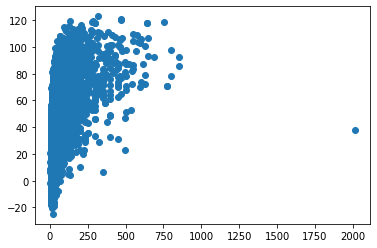

In [96]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [87]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 30.546881522628738


In [88]:
# rf = RandomForestRegressor()

In [140]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_depth=12)

In [141]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [150]:
predicts = rf.predict(X_test)

In [151]:
X_test.shape,y_test.shape

((52500, 81), (52500,))

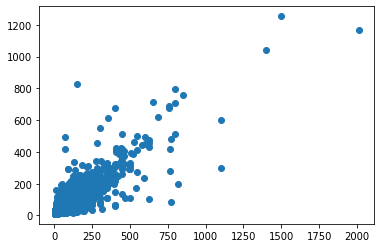

In [152]:
plt.scatter(y_test, predicts)

In [153]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 19.938686401873404


In [78]:
#features_label = X.columns[:]
#importances = rf.feature_importances_
#indices = np. argsort(importances)[::-1]
#for i in range(X.shape[1]):
    #print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

## XGB

In [97]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train,y_train)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [98]:
xgby_pred = xgb_model.predict(X_test)
print('xjb RMSE:', np.sqrt(mean_squared_error(y_test, xgby_pred)))


xjb RMSE: 26.989892524384803


In [79]:
#print(test_data.columns.tolist())

In [154]:
X_test = test_data[['sentiment_1', 'sentiment_2', 'sentiment_3', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
       'winery_0', 'winery_1', 'winery_2', 'winery_3', 'winery_4', 'winery_5',
       'winery_6', 'winery_7', 'winery_8', 'winery_9', 'description_0',
       'description_1', 'description_2', 'description_3', 'description_4',
       'description_5', 'description_6', 'description_7', 'description_8',
       'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3',
       'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8',
       'variety_9', 'province_0', 'province_1', 'province_2', 'province_3',
       'province_4', 'province_5', 'province_6', 'province_7', 'province_8',
       'province_9', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'desc_count', 'id', 'quality', 'points', 
                'sum_desc', 'sum_var', 'sum_prov', 'sum_country']]

In [155]:
# test_data['price'] = rf.predict(X_test)
test_data['price'].head()

175000    159
175001     66
175002     39
175003     35
175004     13
Name: price, dtype: int32

[Text(0, 0, 'sentiment_1'),
 Text(0, 0, 'sentiment_2'),
 Text(0, 0, 'sentiment_3'),
 Text(0, 0, 'region_0'),
 Text(0, 0, 'region_1'),
 Text(0, 0, 'region_2'),
 Text(0, 0, 'region_3'),
 Text(0, 0, 'region_4'),
 Text(0, 0, 'region_5'),
 Text(0, 0, 'region_6'),
 Text(0, 0, 'region_7'),
 Text(0, 0, 'region_8'),
 Text(0, 0, 'region_9'),
 Text(0, 0, 'title_0'),
 Text(0, 0, 'title_1'),
 Text(0, 0, 'title_2'),
 Text(0, 0, 'title_3'),
 Text(0, 0, 'title_4'),
 Text(0, 0, 'title_5'),
 Text(0, 0, 'title_6'),
 Text(0, 0, 'title_7'),
 Text(0, 0, 'title_8'),
 Text(0, 0, 'title_9'),
 Text(0, 0, 'winery_0'),
 Text(0, 0, 'winery_1'),
 Text(0, 0, 'winery_2'),
 Text(0, 0, 'winery_3'),
 Text(0, 0, 'winery_4'),
 Text(0, 0, 'winery_5'),
 Text(0, 0, 'winery_6'),
 Text(0, 0, 'winery_7'),
 Text(0, 0, 'winery_8'),
 Text(0, 0, 'winery_9'),
 Text(0, 0, 'description_0'),
 Text(0, 0, 'description_1'),
 Text(0, 0, 'description_2'),
 Text(0, 0, 'description_3'),
 Text(0, 0, 'description_4'),
 Text(0, 0, 'description_5

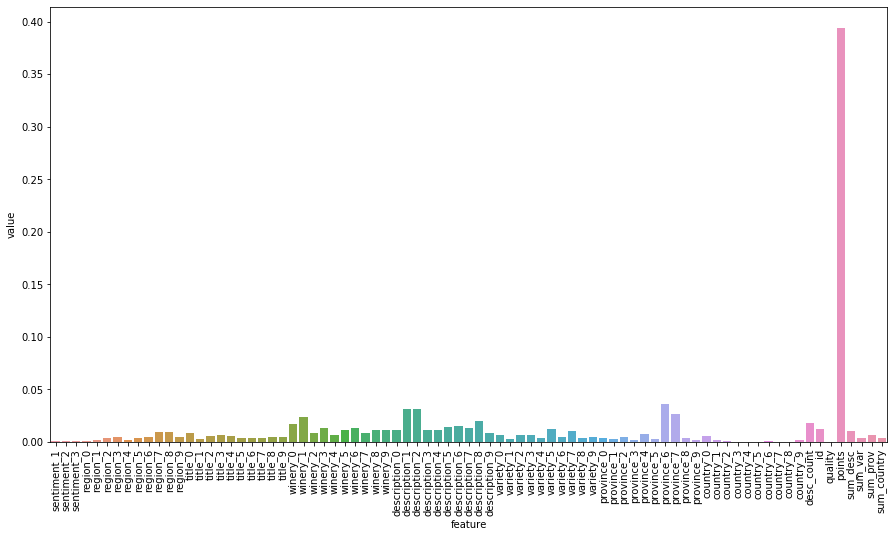

In [156]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)

In [157]:
test_data[['id', 'price']].to_csv('rf_price_predicted19_93.csv', index=False)

In [158]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [104]:
import pickle

In [159]:
pickle.dump(rf,open('rf_model19_93.sav','wb'))

In [160]:
test_data.price.dtype


dtype('int32')

In [116]:
test_data['id'] = test_data['id'].astype('int32')

/home/aims/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [161]:
test_data.id.dtype

dtype('int32')

In [139]:
test_data[['id', 'price']].to_csv('rf_price_predicted20_60.csv', index=False)